# TensorFlow neural networks and evasion attacks
-----
#### Goals:
* build TensorFlow classifier
* perform evasion attacks 
* make classifers resistant to evasion attacks

In [14]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import jdc

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Softmax, Lambda, GaussianNoise
from tensorflow.keras import Model

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import numpy as np
from matplotlib import pyplot as plt

from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod, CarliniLInfMethod

# Dataset
-----
### Load MNIST dataset 

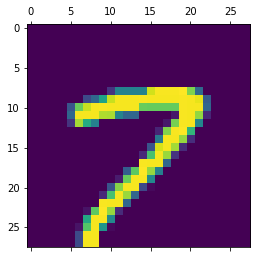

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

plt.matshow(x_train[123])
plt.show()

### Data preparation

In [3]:
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

# Neural network classifier
---
### TensorFlow model for digit recognition

In [4]:
class TfModel(Model):
    
    def __init__(self, filters=4, kernerl_size=4):
        super(TfModel, self).__init__()
        self.conv1 = Conv2D(filters=filters, kernel_size=kernerl_size, activation='relu')
        self.flatten = Flatten()
        self.dense1 = Dense(10, activation='softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.dense1(x)
        return x

### Neural network class for training. Metrics for training and testing

In [5]:
class NeuralNetworkTrainer():
    
    def __init__(self, model):
        self._model = model
        self._loss = tf.keras.losses.SparseCategoricalCrossentropy()
        self._optimizer = tf.keras.optimizers.Adam()
        
        self._train_loss = tf.keras.metrics.Mean(name='train_loss')
        self._train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

        self._test_loss = tf.keras.metrics.Mean(name='test_loss')
        self._test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
        
    def get_classifier(self, nb_classes, input_shape):
        return TensorFlowV2Classifier(
            model          = self._model,
            nb_classes     = nb_classes,
            input_shape    = input_shape, 
            loss_object    = self._loss,               
            clip_values    = (0, 1), 
            channels_first = False
        )

### Train method 

In [6]:
%%add_to NeuralNetworkTrainer

@tf.function
def _train(self, samples, labels):
    with tf.GradientTape() as tape:
        predictions = self._model(samples)
        loss = self._loss(labels, predictions)

    gradients = tape.gradient(loss, self._model.trainable_variables)
    self._optimizer.apply_gradients(zip(gradients, self._model.trainable_variables))
    self._train_loss(loss)
    self._train_accuracy(labels, predictions)

@tf.function
def _test(self, samples, labels):
    predictions = self._model(samples)
    loss = self._loss(labels, predictions)
    self._test_loss(loss)
    self._test_accuracy(labels, predictions)

def train(self, train_ds, test_ds, epoches):
    for epoch in range(epoches):
        for samples, labels in train_ds:
            self._train(samples, labels)

        for test_samples, test_labels in test_ds:
            self._test(test_samples, test_labels)

        print('Epoch {}, Train Accuraccy: {}, Test Accurracy: {}'.format(
            epoch+1, self._train_accuracy.result(), self._test_accuracy.result()))

### Test method

In [7]:
%%add_to NeuralNetworkTrainer

def test(self, x_test, y_test):
    y_test_pred = np.argmax(self._model(x_test), axis=1)
    accuracy_test = np.sum(y_test_pred == y_test) / len(y_test)
    print('Accuracy on test data: {}'.format(accuracy_test))
    return accuracy_test

### Training and evaluating

In [8]:
nn = NeuralNetworkTrainer(TfModel())
nn.train(train_ds, test_ds, epoches=5)
nn.test(x_test, y_test)

Epoch 1, Train Accuraccy: 0.9226833581924438, Test Accurracy: 0.9563999772071838
Epoch 2, Train Accuraccy: 0.9423333406448364, Test Accurracy: 0.9617999792098999
Epoch 3, Train Accuraccy: 0.9521055817604065, Test Accurracy: 0.9659666419029236
Epoch 4, Train Accuraccy: 0.9580374956130981, Test Accurracy: 0.9680500030517578
Epoch 5, Train Accuraccy: 0.962090015411377, Test Accurracy: 0.9701799750328064
Accuracy on test data: 0.9787


0.9787

Prediction: 2:


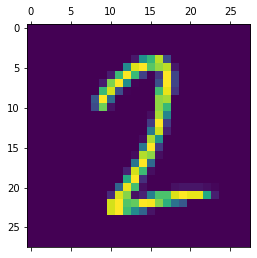

In [9]:
classifier = nn.get_classifier(10, x_train[0].shape)

index = 456

prediction = np.argmax(classifier.model.predict(np.array([x_test[index]])), axis=1)[0]
print('Prediction: {}:'.format(prediction))

plt.matshow(x_test[index])
plt.show()

# Evasion attacks
---
### Fast Gradient Sign Method attack

In [10]:
def perform_attack(attack, x_data, y_data):
    x_data_adv = attack.generate(x_data)
    
    y_data_predictions = np.argmax(classifier.model(x_data_adv), axis=1)
    accuracy_adv = np.sum(y_data_predictions == y_data) / len(y_data)

    perturbation = np.mean(np.abs((x_data_adv - x_data)))

    print('Accuracy on adversarial test data: {}'.format(accuracy_adv))
    print('Average perturbation: {}'.format(perturbation))
    
    return x_data_adv, attack

def perform_fgsm_attack(classifier, x_data, y_data):
    attack = FastGradientMethod(estimator=classifier)
    return perform_attack(attack, x_data, y_data)

Accuracy on adversarial test data: 0.0188
Average perturbation: 0.16788528859615326
After attack:
Prediction: 1:


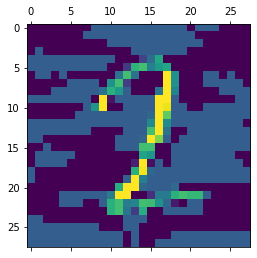

In [11]:
x_test_adv, attack = perform_fgsm_attack(classifier, x_test, y_test)

print('After attack:')

prediction = np.argmax(classifier.model.predict(np.array([x_test_adv[index]])), axis=1)[0]
print('Prediction: {}:'.format(prediction))

plt.matshow(x_test_adv[index])
plt.show()

### Carlini & Wagner Infinity-norm attack

In [12]:
def perform_carlini_wagner_attack(classifier, x_data, y_data):
    attack = CarliniLInfMethod(classifier=classifier, 
                               max_iter=25, 
                               learning_rate=0.06, 
                               initial_const=1e0, 
                               largest_const=2e0)
    return perform_attack(attack, x_data, y_data)

C&W L_inf:   0%|          | 0/10000 [00:00<?, ?it/s]

Accuracy on adversarial test data: 0.304
Average perturbation: 0.0195643100887537
After attack:
Prediction: 1:


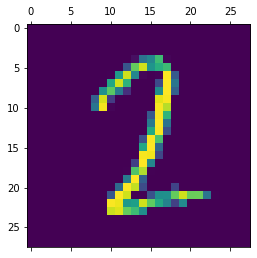

In [13]:
x_test_adv, attack = perform_carlini_wagner_attack(classifier, x_test, y_test)

print('After attack:')

prediction = np.argmax(classifier.model.predict(np.array([x_test_adv[index]])), axis=1)[0]
print('Prediction: {}:'.format(prediction))

plt.matshow(x_test_adv[index])
plt.show()

# Defence
-----
### TensorFlow model for digit recognition with defence 
* softmax with temperature
* adding noise to the input
* additional conv layer

In [71]:
class TfModelV2(Model):
    
    def __init__(self, filters=4, kernerl_size=4, nosie=0.15, temperature=20):
        super(TfModelV2, self).__init__()
        self.noised = GaussianNoise(nosie)
        self.conv1 = Conv2D(filters=filters, kernel_size=kernerl_size, activation='relu')
        self.conv2 = Conv2D(filters=filters, kernel_size=kernerl_size, activation='relu')
        self.flatten = Flatten()
        self.dense1 = Dense(10)
        self.apply_temperature = Lambda(lambda x: x / temperature)
        self.softmax = Softmax()

    def call(self, x):
        x = self.noised(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.apply_temperature(x)
        x = self.softmax(x)
        return x

### Training and evaluating initial model

Epoch 1, Train Accuraccy: 0.8747333288192749, Test Accurracy: 0.9089999794960022
Epoch 2, Train Accuraccy: 0.8954833149909973, Test Accurracy: 0.91839998960495
Epoch 3, Train Accuraccy: 0.9118444323539734, Test Accurracy: 0.933899998664856
Epoch 4, Train Accuraccy: 0.9255625009536743, Test Accurracy: 0.9440749883651733
Epoch 5, Train Accuraccy: 0.9354133605957031, Test Accurracy: 0.9506199955940247
Epoch 6, Train Accuraccy: 0.942550003528595, Test Accurracy: 0.9555666446685791
Epoch 7, Train Accuraccy: 0.948021411895752, Test Accurracy: 0.9593714475631714
Epoch 8, Train Accuraccy: 0.9524103999137878, Test Accurracy: 0.9622750282287598
Epoch 9, Train Accuraccy: 0.95590740442276, Test Accurracy: 0.9644555449485779
Accuracy on test data: 0.9819
Prediction: 1:


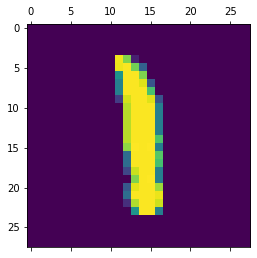

In [73]:
nn_init = NeuralNetworkTrainer(TfModelV2())
nn_init.train(train_ds, test_ds, epoches=9)
nn_init.test(x_test, y_test)

classifier_init = nn_init.get_classifier(10, x_train[0].shape)

index = 777

prediction = np.argmax(classifier_init.model.predict(np.array([x_test[index]])), axis=1)[0]
print('Prediction: {}:'.format(prediction))

plt.matshow(x_test[index])
plt.show()

### Distilled training and evaluating

In [74]:
%%add_to NeuralNetworkTrainer

def for_distilled(self):
    self._loss = tf.keras.losses.KLDivergence()
    self._train_accuracy = tf.keras.metrics.KLDivergence(name='train_accuracy')
    self._test_accuracy = tf.keras.metrics.KLDivergence(name='test_accuracy')


Epoch 1, Train Accuraccy: 0.016006676480174065, Test Accurracy: 0.011327092535793781
Epoch 2, Train Accuraccy: 0.01310366578400135, Test Accurracy: 0.009624303318560123
Epoch 3, Train Accuraccy: 0.010797545313835144, Test Accurracy: 0.007839149795472622
Epoch 4, Train Accuraccy: 0.008969897404313087, Test Accurracy: 0.006480473559349775
Epoch 5, Train Accuraccy: 0.007594899740070105, Test Accurracy: 0.005486546084284782
Epoch 6, Train Accuraccy: 0.006552902050316334, Test Accurracy: 0.004779040813446045
Epoch 7, Train Accuraccy: 0.005754011683166027, Test Accurracy: 0.004240549169480801
Epoch 8, Train Accuraccy: 0.005127692595124245, Test Accurracy: 0.0038155217189341784
Epoch 9, Train Accuraccy: 0.004623468033969402, Test Accurracy: 0.0034653397742658854
Accuracy on test data: 0.9788
Prediction: 1:


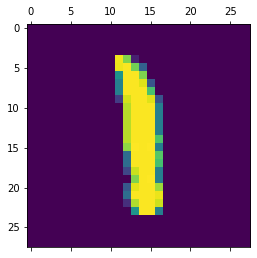

In [75]:
y_train_proba = classifier_init.model(x_train)
y_test_proba = classifier_init.model(x_test)

train_ds_dist = tf.data.Dataset.from_tensor_slices((x_train, y_train_proba)).shuffle(10000).batch(32)
test_ds_dist = tf.data.Dataset.from_tensor_slices((x_test, y_test_proba)).batch(32)

print()

nn_dist = NeuralNetworkTrainer(TfModelV2())
nn_dist.for_distilled()
nn_dist.train(train_ds_dist, test_ds_dist, epoches=9)
nn_dist.test(x_test, y_test)

classifier_dist = nn_dist.get_classifier(10, x_train[0].shape)

prediction = np.argmax(classifier_dist.model.predict(np.array([x_test[index]])), axis=1)[0]
print('Prediction: {}:'.format(prediction))

plt.matshow(x_test[index])
plt.show()

# Train Accuraccy and Test Accurracy are the loss value in this case.  

### Perform Fast Gradient Sign Method attack

Accuracy on adversarial test data: 0.1382
Average perturbation: 0.16706344485282898
After attack:
Prediction: 8:


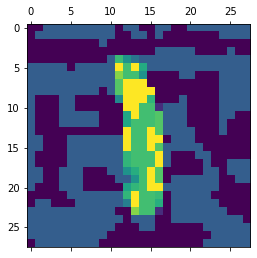

In [76]:
x_test_adv, attack = perform_fgsm_attack(classifier_dist, x_test, y_test)

print('After attack:')

prediction = np.argmax(classifier_dist.model.predict(np.array([x_test_adv[index]])), axis=1)[0]
print('Prediction: {}:'.format(prediction))

plt.matshow(x_test_adv[index])
plt.show()